In [1]:
# Enhanced Random Forest with model based feature selection

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
train_data = pd.read_csv(r"C:\Users\Brad\OneDrive - Ashesi University\Desktop\Ashesi University\Senior Year Sem 2\Capstone 2\Data\fs_train_data_2.csv")

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [6]:
train_data["land_surface_condition"] = encoder.fit_transform(train_data["land_surface_condition"])
train_data["foundation_type"] = encoder.fit_transform(train_data["foundation_type"])
train_data["roof_type"] = encoder.fit_transform(train_data["roof_type"])
train_data["ground_floor_type"] = encoder.fit_transform(train_data["ground_floor_type"])
train_data["other_floor_type"] = encoder.fit_transform(train_data["other_floor_type"])
train_data["position"] = encoder.fit_transform(train_data["position"])
train_data["plan_configuration"] = encoder.fit_transform(train_data["plan_configuration"])

In [7]:
train_data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,count_families,has_secondary_use,damage_grade
0,30,266,1224,1,25,5,2,2,2,0,...,0,1,0,0,0,0,0,0,0,2
1,17,409,12182,2,0,13,7,2,2,0,...,0,1,0,0,0,0,0,1,0,3
2,17,716,7056,2,5,12,6,1,2,1,...,0,1,0,0,0,0,0,1,0,3
3,4,651,105,2,80,5,4,0,2,0,...,0,1,0,0,0,0,0,1,0,2
4,3,1387,3909,5,40,5,10,2,2,0,...,0,0,0,1,0,0,0,1,0,2


In [8]:
x = train_data.iloc[:, :-1].values
y = train_data.iloc[:,23].values

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [10]:
## K, P and Q are selected in the ration 3:2:1 as suggested as optimal

# Number of tree estimators from P for ERF (Q)
n_rf_estimators = 100  #100 is default in sklearn

# Number of High AUC trees selected (P)
n_top_trees = n_rf_estimators * 2

# Number of trees (K)
n_trees = n_rf_estimators * 3


In [11]:
from sklearn.tree import DecisionTreeClassifier

# List to store the trees
trees = []

# Train n_estimators number of trees
for i in range(n_trees):
    
    # Train a decision tree
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    
    # Store the tree
    trees.append(tree)

In [12]:
#Model based Feature Selection

from sklearn.feature_selection import SelectFromModel
fs = SelectFromModel(tree, threshold='median')
fs.fit(X_train,y_train)
fs_features = fs.transform(X_train)

In [13]:
# Print the indices of the selected features
print(fs.get_support(indices=True))

[ 0  1  2  4  5  6  7  9 11 12 15 21]


In [14]:
from sklearn.metrics import roc_auc_score

# Calculate the AUC score for each tree
aucs = []
for tree in trees:
    y_pred = tree.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    aucs.append(auc)

# Sort the trees in descending order of AUC values
trees = [tree for _, tree in sorted(zip(aucs, trees), reverse=True)]

In [15]:
#Select top P trees with high AUC values
top_trees = trees[:n_top_trees]

aucs_top_trees = aucs[:n_top_trees]

aucs_top_trees = np.array(aucs_top_trees).reshape(-1, 1)

from sklearn.cluster import KMeans

# Perform K-Means clustering on the AUC values
kmeans = KMeans(n_clusters=n_rf_estimators)
kmeans.fit(aucs_top_trees)

# Get the cluster labels for each tree
labels = kmeans.labels_




In [16]:
clustered_trees = []
for i in range(n_rf_estimators):
    indices = np.where(labels == i)[0]
    trees_in_cluster = [top_trees[j] for j in indices]
    aucs_in_cluster = [aucs_top_trees[j][0] for j in indices]
    clustered_indices = np.argsort(aucs_in_cluster)[::-1]
    clustered_trees.extend([trees_in_cluster[j] for j in clustered_indices])

In [17]:
ensemble_trees = []
start = 0
for i in range(n_rf_estimators):
    end = start + len(np.where(labels == i)[0])
    ensemble_tree = clustered_trees[start]
    ensemble_trees.append(ensemble_tree)
    start = end


In [18]:
# Fit each decision tree to the training data
for ensemble_tree in ensemble_trees:
    tree.fit(X_train, y_train)

# Predict the class labels for the test data using each decision tree
y_pred_list = [ensemble_tree.predict(X_test) for ensemble_tree in ensemble_trees]

# Convert the list of predictions into a matrix
y_pred_matrix = np.array(y_pred_list).T

# Use the majority vote of the predictions to make an ensemble classification decision
y_pred = np.array([np.bincount(y).argmax() for y in y_pred_matrix])


In [19]:
from sklearn.metrics import classification_report

# Obtain a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           1       0.48      0.52      0.50      4971
           2       0.71      0.71      0.71     29703
           3       0.62      0.62      0.62     17447

    accuracy                           0.66     52121
   macro avg       0.60      0.61      0.61     52121
weighted avg       0.66      0.66      0.66     52121



In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

axis_tick_labels = ['Grade 1', 'Grade 2', 'Grade 3']


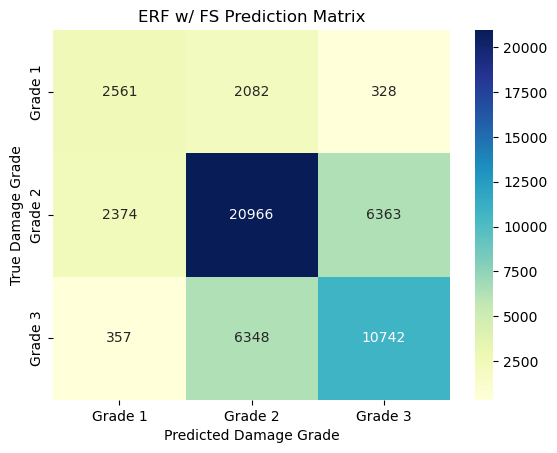

In [21]:
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=axis_tick_labels, yticklabels=axis_tick_labels)
plt.title("ERF w/ FS Prediction Matrix")
plt.xlabel("Predicted Damage Grade")
plt.ylabel("True Damage Grade")
plt.show()

SyntaxError: invalid syntax (395154059.py, line 1)

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
